#### References:
1. https://www.kaggle.com/toregil/welcome-to-deep-learning-cnn-99

In [8]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [9]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

In [10]:
import time
import os
import pandas as pd

project_name = 'Dog_Breed_Identification'
step_name = 'Train'
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)

cwd = os.getcwd()
model_path = os.path.join(cwd, 'model')
print('model_path: ' + model_path)

run_name: Dog_Breed_Identification_Train_20171024_192312
model_path: D:\Kaggle\Digit_Recognizer\model


In [11]:
train_file = ".\\input\\train.csv"
test_file = ".\\input\\test.csv"
output_file = ".\\output\\submission.csv"

In [12]:
raw_data = np.loadtxt(train_file, skiprows=1, dtype='int', delimiter=',')
x_train, x_val, y_train, y_val = train_test_split(raw_data[:,1:], raw_data[:,0], test_size=0.1)

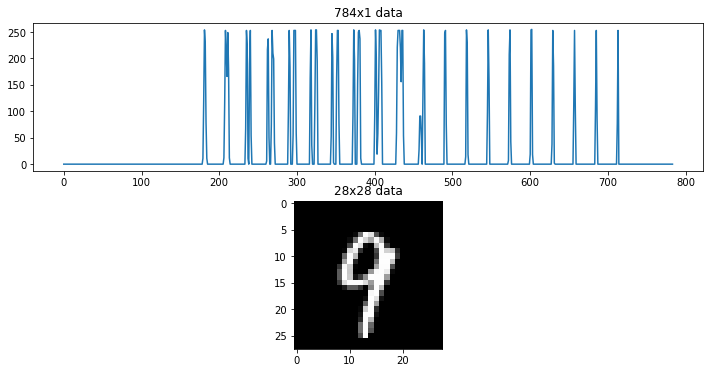

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(12,6))
ax[0].plot(x_train[0])
ax[0].set_title('784x1 data')
ax[1].imshow(x_train[0].reshape(28,28), cmap='gray')
ax[1].set_title('28x28 data')

(37800, 784)
(37800, 28, 28, 1)
(28, 28, 1)


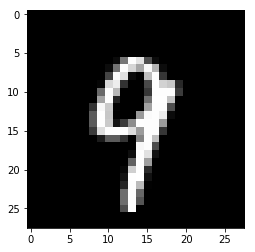

In [14]:
print(x_train.shape)
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)
print(x_train.shape)
print(x_train[0].shape)
plt.imshow(x_train[0].reshape(28, 28), cmap='gray')

In [15]:
x_train = x_train.astype("float32")/255.
x_val = x_val.astype("float32")/255.

In [16]:
print(y_train[0])
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
#example:
print(y_train[0])

9
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


In [17]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
#model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
#model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [18]:
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)

In [19]:
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])

In [20]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

log_dir = os.path.join(model_path, run_name)
print('log_dir:' + log_dir)
tensorBoard = TensorBoard(log_dir=log_dir)

log_dir:D:\Kaggle\Digit_Recognizer\model\Dog_Breed_Identification_Train_20171024_192312


In [21]:
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=16),
                           steps_per_epoch=500,
                           epochs=10, #Increase this when not on Kaggle kernel
                           verbose=1,  #1 for ETA, 0 for silent
                           validation_data=(x_val[:400,:], y_val[:400,:]), #For speed
                           callbacks=[annealer, tensorBoard])

Epoch 1/10
500/500 [==============================] - 15s - loss: 1.4921 - acc: 0.4950 - val_loss: 0.7314 - val_acc: 0.7925
Epoch 2/10
500/500 [==============================] - 14s - loss: 0.6686 - acc: 0.7885 - val_loss: 0.1262 - val_acc: 0.9675
Epoch 3/10
500/500 [==============================] - 15s - loss: 0.4372 - acc: 0.8668 - val_loss: 0.0477 - val_acc: 0.9850
Epoch 4/10
500/500 [==============================] - 15s - loss: 0.3640 - acc: 0.8935 - val_loss: 0.1185 - val_acc: 0.9675
Epoch 5/10
500/500 [==============================] - 15s - loss: 0.3022 - acc: 0.9133 - val_loss: 0.0365 - val_acc: 0.9950
Epoch 6/10
500/500 [==============================] - 15s - loss: 0.2469 - acc: 0.9291 - val_loss: 0.0274 - val_acc: 0.9925
Epoch 7/10
500/500 [==============================] - 15s - loss: 0.2328 - acc: 0.9333 - val_loss: 0.0210 - val_acc: 0.9950
Epoch 8/10
500/500 [==============================] - 17s - loss: 0.2146 - acc: 0.9385 - val_loss: 0.0196 - val_acc: 0.9925
Epoch 9/

In [22]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.0395, final accuracy: 0.9886


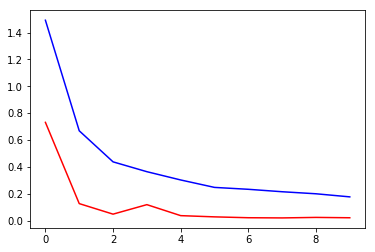

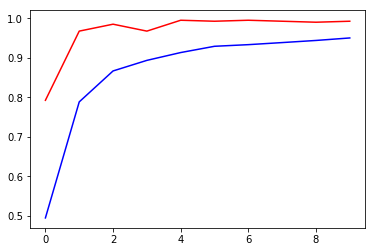

In [23]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [24]:
y_hat = model.predict(x_val)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[382   0   0   0   1   0   0   0   1   0]
 [  0 509   3   0   0   0   0   1   0   0]
 [  1   1 440   1   0   0   0   3   0   1]
 [  0   0   2 428   0   2   0   2   1   0]
 [  0   0   1   0 419   0   1   0   0   5]
 [  1   0   0   1   0 364   2   0   0   0]
 [  0   0   0   0   0   0 403   0   0   0]
 [  0   2   1   0   0   0   0 424   0   1]
 [  0   0   0   0   0   0   3   0 377   2]
 [  1   1   0   0   5   0   0   1   0 406]]


In [25]:
mnist_testset = np.loadtxt(test_file, skiprows=1, dtype='int', delimiter=',')
x_test = mnist_testset.astype("float32")
x_test = x_test.reshape(-1, 28, 28, 1)/255.

In [26]:
y_hat = model.predict(x_test, batch_size=64)

In [27]:
y_pred = np.argmax(y_hat,axis=1)

In [28]:
with open(output_file, 'w') as f :
    f.write('ImageId,Label\n')
    for i in range(len(y_pred)) :
        f.write("".join([str(i+1),',',str(y_pred[i]),'\n']))

In [29]:
print('Done!')

Done!
